# Inverting probability generating functions

In most cases of interest, the PGF $G(x)$ is known *indirectly*, i.e., we know how to compute its value for any $x$, but we do not know the underlying coefficients. 
For instance, the PGF for the result of a roll of two six-sided dice is $G(x) = g(x)^2$, where 

$$
g(x) = \sum_{n = 1}^6 \frac{1}{6} x^n
$$

is the PGF for the result of a roll of a single dice.
While in this example it is straightforward to evaluate the coefficients, in many applications, $G(x)$ is constructed by multiplying and composing multiple functions together.
In this chapter, we describe a systematic approach to extract the distribution $(p_n)_{n = 0}^\infty$ from an arbitrary PGF $G(x)$.

By definition, the $n$-th term of the power series of $G(x)$ is

$$
p_n = \left.\frac{1}{n!} \frac{\mathrm{d}^n}{\mathrm{d}x^n} G(x) \right|_{x = 0}
$$

Using [Cauchy's integral formula](https://en.wikipedia.org/wiki/Cauchy%27s_integral_formula), we can transform this into an integral in the complex plane. Using a circle of radius $r$ as a contour around the origin (and brushing over the mathematical steps), we end up with the following Fourier integral to evaluate:

$$
p_n = \frac{1}{2\pi r^n}\int_{0}^{2\pi} G\left ( r e^{ i \omega} \right) e^{- i \omega n} \mathrm{d} \omega \;.
$$

To verify that this formulae is true, expand $G(r e^{i\omega})$ in a power series inside the integral to realize that only the $n$-th degree term contribute to the integral, all other terms are zero.

:::{seealso}
When we choose $r = 1$, the term $G(e^{i\omega})$ corresponds to the  [characteristic function](https://en.wikipedia.org/wiki/Characteristic_function_(probability_theory)) of the random variable.
:::

## Polynomial generating function

If $G(x)$ is a polynomial of degree $N-1$, meaning $p_n = 0$ for all $n \geq N$, then the probability distribution is recovered exactly from a discrete Fourier transform

$$
p_n = \frac{1}{N r^n} \sum_{m = 0}^{N-1} G(r e^{2 \pi i m /N}) e^{2 \pi i n m /N} \;.
$$

Again, one can verify that this is true by expanding $G(e^{2\pi i m /N})$ into a power series and noting that only the $n$-th degree term is nonzero.
Let us apply this technique to recover the distribution for the roll of two six-sided dice. 
For the sake of simplicity, let us use $r = 1$ for now.

:::{note}
Since $g(x)$ is a polynomial of degree $6$, $G(x)$ is of degree $12$ and $N = 13$. 
:::

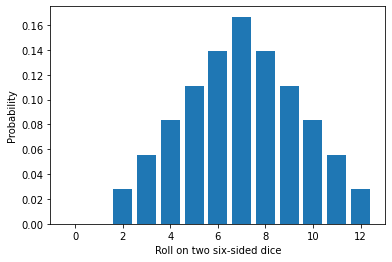

In [1]:
import numpy as np
import matplotlib.pyplot as plt

g = lambda x: np.sum([x**n/6 for n in range(1,7)])
G = lambda x: g(x)**2
G = np.vectorize(G)
N = 13
n = np.arange(N)
c = np.exp(2*np.pi*1j*n/N)
pn = abs(np.fft.fft(G(c))/N)
plt.bar(n,pn)
plt.ylabel('Probability')
plt.xlabel('Roll on two six-sided dice')
plt.show()

## General probability generating function

For probability generating functions that cannot be represented as a finite degree polynomial (or for very large degree), using the above discrete Fourier transform with some finite $N$ allows us to recover **approximately** the first $N$ terms of the distribution.
But how good is this approximation?
To find out, let us use $N = 10$ in the previous example.

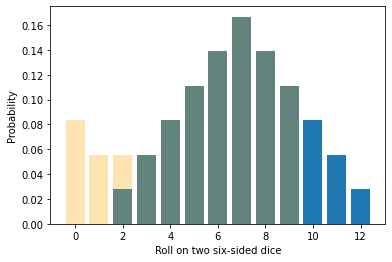

In [2]:
N_ = 10
n_ = np.arange(N_)
c_ = np.exp(2*np.pi*1j*n_/N_)
pn_ = abs(np.fft.fft(G(c_))/N_)
plt.bar(n,pn)
plt.bar(n_,pn_, alpha = 0.3, color='orange')
plt.ylabel('Probability')
plt.xlabel('Roll on two six-sided dice')
plt.show()

The original (exact) distribution is shown in dark green and blue.
The new distribution correspond to the orange and dark green portion.
What happened is that the probability mass for the terms $p_n$ with $n \geq N$ (in blue) was moved at the beginning of the distribution (in orange).
This phenomenon is known as *aliasing* and can affect significantly our results if $N$ is too small and the tail of $p_n$ does not decrease fast enough.
One obvious strategy is to increase $N$, which is perfectly acceptable when the terms $G(e^{2\pi i m /N})$ are not too costly to evaluate.
Sometimes increasing $N$ is computationally expansive and we care only about the first few terms.
In this case, we can use a value $0 < r < 1$ into our discrete Fourier transform to mitigate the effect of aliasing, as shown below.

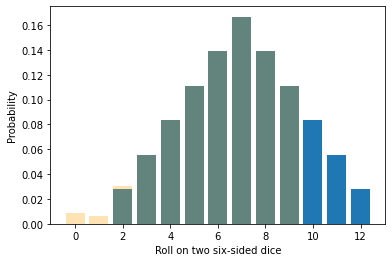

In [3]:
r = 0.8
N_ = 10
n_ = np.arange(N_)
c_ = np.exp(2*np.pi*1j*n_/N_)
pn_ = abs(np.fft.fft(G(r*c_))/(N_*r**n_))
plt.bar(n,pn)
plt.bar(n_,pn_, alpha = 0.3, color='orange')
plt.ylabel('Probability')
plt.xlabel('Roll on two six-sided dice')
plt.show()

Here is another example usign the PGF for a Poisson distribution, with varying values of $r$.

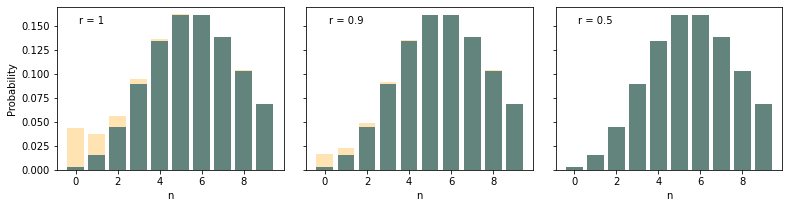

In [4]:
from scipy.special import loggamma
fig, axes = plt.subplots(1,3, figsize=(13,3), sharey=True)
plt.subplots_adjust(wspace = 0.1)

mean = 6
G = lambda x: np.exp(mean*(x-1))
N = 10
n = np.arange(N)
c = np.exp(2*np.pi*1j*n/N)
pn_true = mean**n*np.exp(-mean - loggamma(n+1))
for j,r in enumerate([1,0.9,0.5]):
    pn = abs(np.fft.fft(G(r*c))/(N*r**n))
    axes[j].bar(n,pn_true)
    axes[j].bar(n,pn, color='orange', alpha=0.3)
    if j == 0:
        axes[j].set_ylabel('Probability')
    axes[j].set_xlabel('n')
    axes[j].text(0.1,0.9,f'r = {r}', transform=axes[j].transAxes)
plt.show()

To understand what is happening, we can write our discrete Fourier transform approximation $\hat{p}_n$ as

$$
\hat{p}_n = p_n + \sum_{a = 1}^\infty p_{n + aN} r^{aN} \;.
$$

Again, this is obtained by expanding $G(r e^{i \omega})$ inside the integrale.
The aliasing effect corresponds to the second term on the right.
Since the sum starts with $a = 1$, the error term is $O(r^N)$, so picking a value $r < 1$ reduces considerably the error.

:::{tip}
While it is tempting to choose a very small $r$, it may cause numerical issues due to the floating point representation of real numbers since we needs to divide by $r^n$ to obtain $p_n$.
To fix a reasonable $r$, we can rewrite $r \iff e^{-1/\kappa}$, where $\kappa$ is the exponential cut-off value.
Fixing $\kappa$ to a few orders of magnitude smaller than $N$ is usually sufficient.
For instance, with $\kappa = 1$, $r \approx 0.368$, which would be sufficient above with the Poisson PGF, and this is only one order order of magnitude smaller than $N$.
:::